In [8]:
# imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, math, site

In [13]:
# --- Inputs and Outputs ---
# output path
folder = os.path.expanduser('Z:\\FY24-sshi-Last10pctProject\\national runs\\decarb plots')
outpath = os.path.join(folder, 'maps') 
reedspath = 'C:\\Users\sshi\\Documents\\GitHub\ReEDS-2.0'

# run(s) of interest
runs_folder = 'Z:\\FY24-sshi-Last10pctProject\\national runs'

# MODIFY ME
#'''
# -- scenarios WITH fuel cell deployment
scenarios = [os.path.join(runs_folder, '1_USA_decarb'), 
             os.path.join(runs_folder, '1_USA_high_RE_costs'), 
             os.path.join(runs_folder, '1_USA_low_RE_costs'),
             os.path.join(runs_folder, '1_USA_reduced_RE_availability'), 
             os.path.join(runs_folder, '1_USA_no_CCS'), 
             os.path.join(runs_folder, '1_USA_high_electrification'),
             os.path.join(runs_folder, '1_USA_high_FC_deploy'),
             os.path.join(runs_folder, '1_USA_low_FC_deploy')]
'''
# -- scenarios WITHOUT fuel cell deployment
scenarios = [os.path.join(runs_folder,'1_USA_noFC_decarb'), 
             os.path.join(runs_folder, '1_USA_noFC_high_RE_costs'), 
             os.path.join(runs_folder, '1_USA_noFC_low_RE_costs'),
             os.path.join(runs_folder, '1_USA_noFC_reduced_RE_availability'), 
             os.path.join(runs_folder, '2_USA_noFC_no_CCS'),
             #os.path.join(runs_folder, '1_USA_noFC_high_FC_deploy'),
             #os.path.join(runs_folder, '1_USA_noFC_low_FC_deploy'),
             os.path.join(runs_folder, '1_USA_noFC_high_electrification')]
'''

# filter data, MODIFY ME
tech_ls = ['fuel-cell']
national_bas = [f'p{x}' for x in range(1,135)]
year = 2050
agg_level = 'r' # choose 'st' for the state level or 'r' for the ReEDS BA level, 'county' for county, mixed for mixed resolution runs

# scenarios
scen_df = pd.DataFrame(['Decarb','High RE Costs','Low RE Costs','Reduced RE',
                        'No CCS','High Electrification',
                        'Low FC Costs','High FC Costs'
                        ], columns=['scenario'])

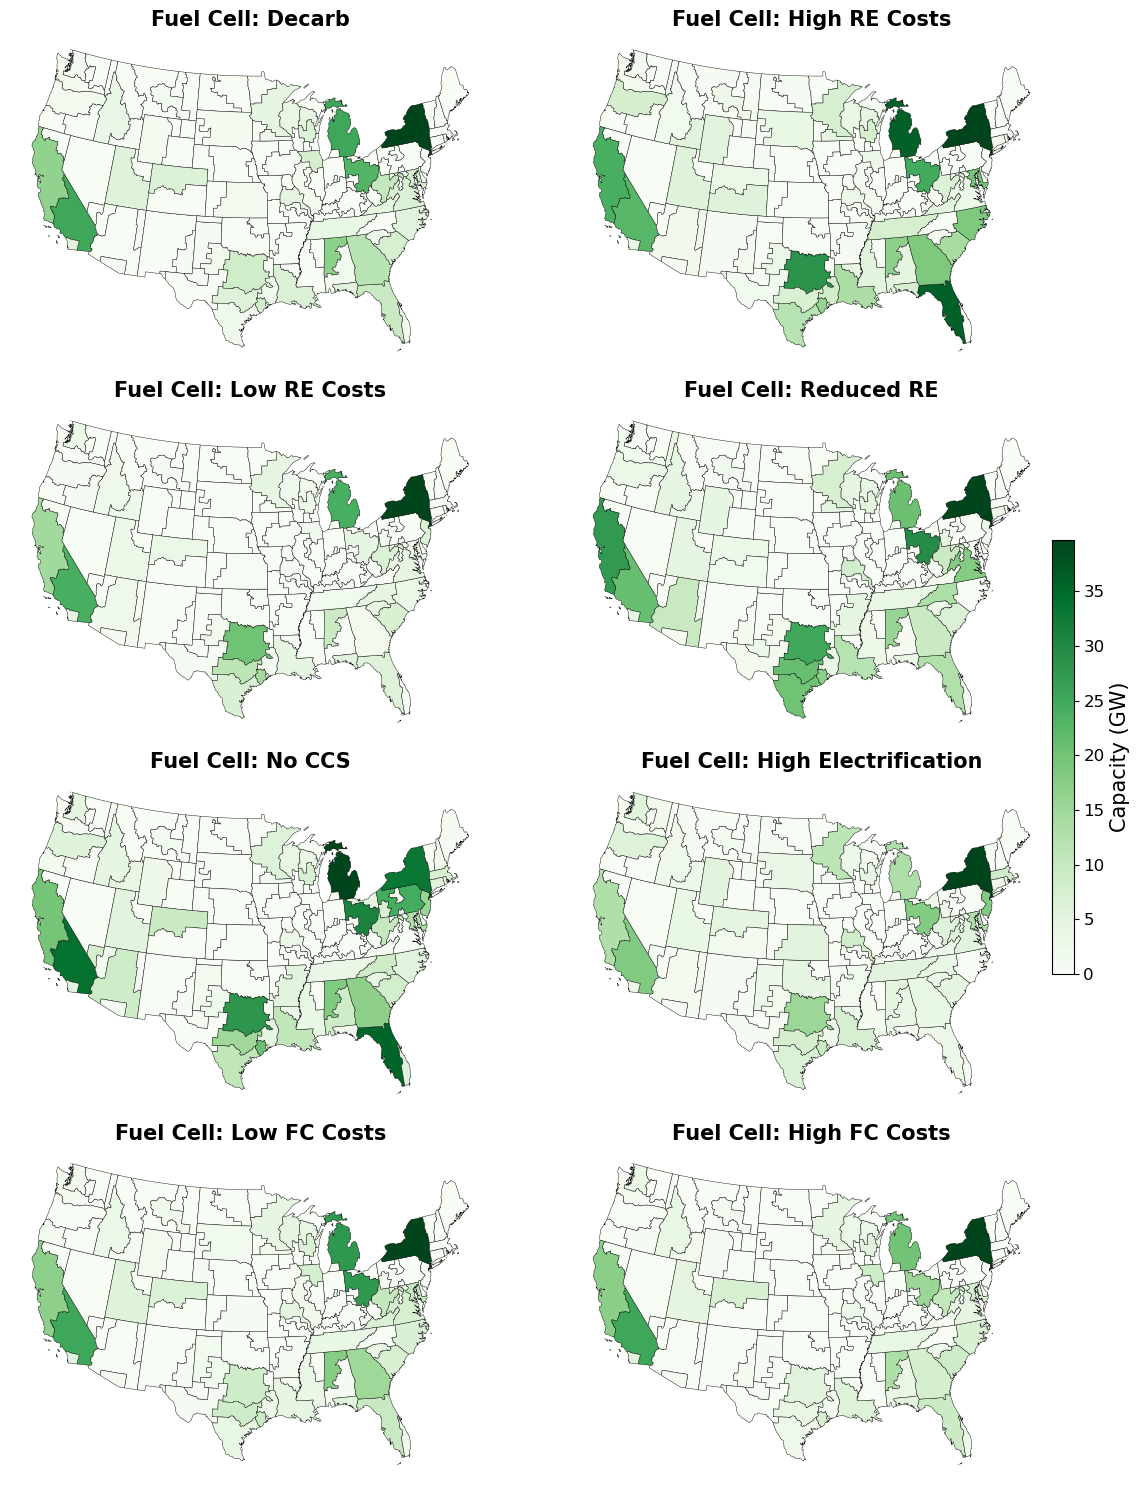

In [14]:
# plot data setup
# Use 3 rows for No FC, 4 row for with FC
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15), sharex=True, sharey=True)  

# Ensure 'axes' is a 1D array for easy iteration
axes = axes.flatten()

# pull in the BA region shapefile
reeds_gdf = gpd.read_file(os.path.join(reedspath,'inputs','shapefiles','US_PCA','US_PCA.shp')).rename(columns = {'rb':'r'})

# list to find the upper list for color bar
vmax_ls = []

#  Loop through each scenario and plot
for scenario_idx, scenario_path in enumerate(scenarios):
    # Load data for each scenario
    df = pd.read_csv(os.path.join(scenario_path, 'outputs', 'cap.csv')).rename(columns={'Value':'capacity_MW'})

    # Dictionary to store capacity data for each technology
    cap_by_tech = {}

    for tech in tech_ls:
        # filter data for the selected technology in tech_name
        #cap_by_tech = df[df['i'].str.contains(tech_name)] 
        cap_by_tech[tech]= df[df['i'].str.contains(tech)] 

        #group the same year and in the same region for each data frame
        cap_by_tech[tech] = cap_by_tech[tech].groupby(['r','t'], as_index=False).sum()

        #take capaicty for the speficied year in each region 
        cap_by_tech[tech] = cap_by_tech[tech][cap_by_tech[tech]['t'] == year]

        # convert capacity from MW to GW
        cap_by_tech[tech]['capacity_GW'] = cap_by_tech[tech]['capacity_MW'] / 10**3

        # map regions, the 'r' column to BAs
        ba_df = pd.DataFrame(national_bas,columns=['r'])
        # Merge data with ba mapping
        cap_by_tech[tech] = ba_df.merge(cap_by_tech[tech], how='left').fillna(0)
        cap_by_tech[tech] = cap_by_tech[tech].groupby(['r']).sum()

        # Merge data with shapefile
        dfmap = reeds_gdf.merge(cap_by_tech[tech], how='inner', on=agg_level)
        vmax = dfmap['capacity_GW'].max()
        vmax_ls.append(vmax)

    # plot the data
    ax=axes[scenario_idx]
    dfmap.plot(ax=ax, column='capacity_GW',
               cmap='Greens',  # MODIFY ME
               edgecolor="black", linewidth=0.3, 
               legend_kwds={ 'label' : 'Capacity GW'}, vmax = vmax,figsize=(8,7))

    # plot apeearance
    agg_name = 'BA'
    ax.patch.set_facecolor('white')

    # set title, MODIFY ME
    ax.set_title(f'Fuel Cell: {scen_df.scenario[scenario_idx]}', fontsize=15, fontweight='bold')
    #ax.set_title(f'{tech_name.upper()}: {scen_df.scenario[scenario_idx]}', fontsize=15, fontweight='bold')

    ax.axis('off')

# Add a colorbar for all subplots
norm = colors.Normalize(vmin=0, vmax=max(vmax_ls))
sm = plt.cm.ScalarMappable(cmap='Greens', norm=norm) # set color, MODIFY ME
sm.set_array([])

# Adjust layout and save plot
plt.tight_layout()
cbar = plt.colorbar(sm, ax=axes, orientatio+n='vertical', shrink=0.3, pad=0.0, label='Capacity GW', location='right')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Capacity (GW)', fontsize=15)

# set saved figure name, MODIFY ME
plt.savefig(os.path.join(outpath, f'Fuel Cell_{year}_{agg_name}.png'), dpi=300)